In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc


In [2]:
EPOCHS = 10
BATCH_SIZE = 128

In [3]:
#Reading the train dataset
data = pd.read_csv('train.csv')
# data = data.sample(frac=0.02,random_state=200)
# data.head()

In [4]:
#checking unique numbers in train label column
unique = data['label'].unique()
print("Unique Numbers :",unique)

#countine the unique number of digits for classification
n_classes = len(unique)
print("Number of classes :",n_classes)

Unique Numbers : [1 0 4 7 3 5 8 9 2 6]
Number of classes : 10


In [5]:
#Filtering the dataset between X and Y
x = data.drop(labels = ["label"], axis=1)
y = data['label']

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=42,stratify=y)
# # normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
print(x_train.to_numpy().shape,x_test.to_numpy().shape)

(33600, 784) (8400, 784)


In [7]:
class Layers_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        # self.biases = np.full((1, n_neurons), 0.001)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        self.inputs = inputs

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues,self.weights.T)

class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0,inputs)
        self.inputs = inputs
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class customActivation:
    def __init__(self, n_inputs):
        self.weights = 0.01 * np.random.randn(1, n_inputs)
        self.biases = 0.01 * np.random.randn(1, n_inputs)
        print('k1:',self.weights, 'k0:', self.biases)

    def forward(self, inputs):
        self.output = np.multiply(inputs, self.weights) + self.biases
        self.inputs = inputs
    
    def backward(self, dvalues):
        self.dinputs = np.multiply(dvalues, self.weights)
        self.dweights = np.mean(self.dinputs, axis=0, keepdims=True)
        self.dbiases = np.mean(dvalues, axis=0, keepdims=True)

class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probalities = exp_values / np.sum(exp_values , axis = 1, keepdims=True)
        self.output = probalities
    
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        for index, (single_output, single_dvalues) in enumerate(zip(self.output,dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_CategorialCrossrntropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        if len(y_true.shape) == 1:
            correct_confidence = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidence = np.sum(y_pred_clipped * y_true, axis = 1)
        negative_log_likelihoods = -np.log(correct_confidence)
        return negative_log_likelihoods
    
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        lables = len(dvalues[0])
        if len(y_true.shape) == 1:
            y_true = np.eye(lables)[y_true]
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples

class Activation_Softmax_Loss_CategorialCrossrntropy():
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategorialCrossrntropy()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -=1
        self.dinputs = self.dinputs / samples

class Optimizer_SGD:
    def __init__(self, learning_rate= 1.0, decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iteration = 0
        self.momentum = momentum

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iteration))
    
    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        layer.weights += weight_updates
        layer.biases += bias_updates
    
    def post_update_params(self):
        self.iteration += 1


dense1 = Layers_Dense(784, 392)
activation1 = customActivation(392)
dense2 = Layers_Dense(392, 10)
loss_activation = Activation_Softmax_Loss_CategorialCrossrntropy()
optimizer = Optimizer_SGD(decay=1e-3, momentum=0.9)  

steps_train = x_train.to_numpy().shape[0] // BATCH_SIZE
info = {'train_loss': [] , 'test_loss': [] , 'train_acc':[], 'test_acc': []}



dense1.forward(x_train.to_numpy())
activation1.forward(dense1.output)

dense2.forward(activation1.output)
loss = loss_activation.forward(dense2.output, y_train.to_numpy())
predictions = np.argmax(loss_activation.output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y_train.to_numpy(), axis=1)
accuracy = np.mean(predictions == y_train.to_numpy())
info['train_loss'].append(loss)
info['train_acc'].append(accuracy)
print(f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f}, ' + f'lr: {optimizer.current_learning_rate}')

dense1.forward(x_test.to_numpy())
activation1.forward(dense1.output)

dense2.forward(activation1.output)
loss = loss_activation.forward(dense2.output, y_test.to_numpy())
predictions = np.argmax(loss_activation.output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y_test.to_numpy(), axis=1)
accuracy = np.mean(predictions == y_test.to_numpy())
info['test_loss'].append(loss)
info['test_acc'].append(accuracy)
print(f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f}, ' +
        f'lr: {optimizer.current_learning_rate}')

for epoch in range(EPOCHS):
    for step in range(steps_train):
        x_batch = x_train[step*BATCH_SIZE:(step+1)*BATCH_SIZE]
        y_batch = y_train[step*BATCH_SIZE:(step+1)*BATCH_SIZE]

        dense1.forward(x_batch.to_numpy())
        activation1.forward(dense1.output)

        dense2.forward(activation1.output)
        loss = loss_activation.forward(dense2.output, y_batch.to_numpy())

        predictions = np.argmax(loss_activation.output, axis=1)
        if len(y.shape) == 2:
            y = np.argmax(y_batch.to_numpy(), axis=1)
        accuracy = np.mean(predictions == y_batch.to_numpy())

        # if not epoch % 100:
        #     print(f'epoch:{epoch}, ' +
        #         f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f}, ' +
        #         f'lr: {optimizer.current_learning_rate}')

        loss_activation.backward(loss_activation.output, y_batch.to_numpy())
        dense2.backward(loss_activation.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)

        optimizer.pre_update_params()
        optimizer.update_params(dense1)
        optimizer.update_params(activation1)
        optimizer.update_params(dense2)
        optimizer.post_update_params()
    
    dense1.forward(x_train.to_numpy())
    activation1.forward(dense1.output)

    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y_train.to_numpy())
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y_train.to_numpy(), axis=1)
    accuracy = np.mean(predictions == y_train.to_numpy())
    print(f'epoch:{epoch}, ' +
          f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f}, ' +
          f'lr: {optimizer.current_learning_rate}')
    info['train_loss'].append(loss)
    info['train_acc'].append(accuracy)

    dense1.forward(x_test.to_numpy())
    activation1.forward(dense1.output)

    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y_test.to_numpy())
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y_test.to_numpy(), axis=1)
    accuracy = np.mean(predictions == y_test.to_numpy())
    print(f'test - epoch:{epoch}, ' +
          f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f}, ' +
          f'lr: {optimizer.current_learning_rate}')
    info['test_loss'].append(loss)
    info['test_acc'].append(accuracy)

k1: [[-8.89511116e-03  5.23336366e-03 -1.06932397e-02  4.45728397e-03
   2.40355181e-03 -6.47764860e-03  1.61557570e-02 -8.36140787e-03
   3.93018427e-03  2.65778104e-03  1.65130032e-02 -1.40250756e-02
  -7.78692808e-03 -2.49844081e-03 -1.35254267e-02  1.17857602e-02
  -1.19012881e-02 -1.08443549e-02 -1.03810918e-02 -5.35125753e-03
  -3.03736657e-03 -1.75693757e-02  7.16726656e-03  3.23883787e-03
  -1.23913747e-02 -1.31945539e-02 -2.66297025e-03 -6.17728942e-03
   4.02523652e-03  4.54587586e-03 -8.81859873e-03  2.49729689e-03
  -2.53572375e-03  1.42688061e-02  3.61927406e-03 -1.35686904e-02
   5.87167946e-03  1.28451383e-02 -7.14959694e-03  1.86209698e-02
   5.69586787e-03  1.24582834e-02 -1.93124172e-02 -1.63984369e-02
  -2.25886928e-02 -3.43417686e-04 -1.28105925e-02 -1.36801464e-02
   1.83247466e-02  1.75360617e-03 -7.55248243e-04  2.38260087e-03
   2.38183490e-03 -2.22188468e-02  1.56832260e-02  2.33213568e-02
   9.25650366e-03  4.20507014e-03  2.75839551e-03 -1.21955049e-02
  -7.1

In [8]:
print(info['train_loss'])
print(info['train_acc'])

print(info['test_loss'])
print(info['test_acc'])

[2.3026631496008894, 0.39100470492480127, 0.3243307363094053, 0.30209641574662305, 0.2894283602464136, 0.28055652253669067, 0.27398558143316415, 0.2688088722171248, 0.26456065693630265, 0.2610264260320869, 0.25809095030399226]
[0.09895833333333333, 0.8868154761904762, 0.9075, 0.9158928571428572, 0.9184821428571428, 0.920327380952381, 0.9230059523809524, 0.924970238095238, 0.9259821428571429, 0.9270238095238095, 0.9276785714285715]
[2.302661118810443, 0.39484177874207144, 0.3355171007818289, 0.31849376700804666, 0.31017351284584566, 0.3048479281152066, 0.3010695851506112, 0.2981330810125274, 0.2957629672774805, 0.29386399213042097, 0.2923857024854099]
[0.09916666666666667, 0.8826190476190476, 0.9019047619047619, 0.9069047619047619, 0.9103571428571429, 0.9107142857142857, 0.9119047619047619, 0.9130952380952381, 0.9133333333333333, 0.9138095238095238, 0.9136904761904762]


In [9]:
print('k1:',activation1.weights, 'k0:', activation1.biases)


k1: [[-8.87301092e-03  5.22703529e-03 -1.07066000e-02  4.43866721e-03
   2.40874552e-03 -6.45549871e-03  1.60086129e-02 -8.36490382e-03
   3.94254707e-03  2.65726911e-03  1.65289856e-02 -1.41849664e-02
  -7.83545133e-03 -2.50899743e-03 -1.35103990e-02  1.16982307e-02
  -1.18361053e-02 -1.08316044e-02 -1.03938118e-02 -5.34363199e-03
  -3.03443066e-03 -1.75412213e-02  7.14572763e-03  3.24980420e-03
  -1.23598121e-02 -1.32288315e-02 -2.67987019e-03 -6.19851740e-03
   4.01740946e-03  4.55678514e-03 -8.80586892e-03  2.49390457e-03
  -2.52019780e-03  1.44167181e-02  3.64283456e-03 -1.35923008e-02
   5.87206792e-03  1.28688819e-02 -7.15064049e-03  1.87523221e-02
   5.65439886e-03  1.25691784e-02 -1.94058557e-02 -1.63533730e-02
  -2.20100146e-02 -3.45482266e-04 -1.27910150e-02 -1.35432817e-02
   1.84377893e-02  1.74482590e-03 -7.55802984e-04  2.38354692e-03
   2.38544726e-03 -2.28157604e-02  1.57698667e-02  2.31688374e-02
   9.22203797e-03  4.19426187e-03  2.75890972e-03 -1.22240651e-02
  -7.1

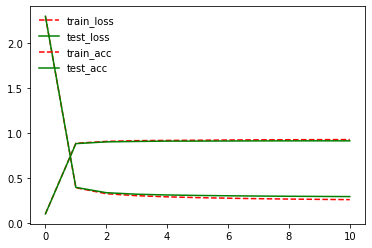

In [10]:
plt.plot(range(len(info['train_loss'])), info['train_loss'], '--r', label='train_loss')
plt.plot(range(len(info['test_loss'])), info['test_loss'], color='green', label='test_loss')
plt.plot(range(len(info['train_acc'])), info['train_acc'], '--r', label='train_acc')
plt.plot(range(len(info['test_acc'])), info['test_acc'], color='green', label='test_acc')
plt.legend(loc='upper left', frameon=False)